In [1]:
# Install and import dependencies
!pip install kagglehub pandas numpy scikit-learn matplotlib seaborn

import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download and load the dataset using kagglehub
try:
    # Download the brendan45774/test-file dataset
    path = kagglehub.dataset_download("brendan45774/test-file")
    print("Dataset downloaded at:", path)

    # Load the dataset (test.csv)
    data = pd.read_csv(f"{path}/tested.csv")
    print("Dataset shape:", data.shape)
    data.head()
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please upload test.csv manually or ensure kagglehub authentication in Cell 0.")
    from google.colab import files
    uploaded = files.upload()
    data = pd.read_csv('tested.csv')
    print("Manually uploaded dataset shape:", data.shape)

Dataset downloaded at: /kaggle/input/test-file
Dataset shape: (418, 12)


In [3]:
# Data preprocessing
# Drop irrelevant columns
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Define features and target
X = data.drop(columns=['Survived'])
y = data['Survived']

# Define numerical and categorical columns
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training set shape:", X_train_processed.shape)
print("Processed testing set shape:", X_test_processed.shape)

# Get feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

Processed training set shape: (334, 12)
Processed testing set shape: (84, 12)


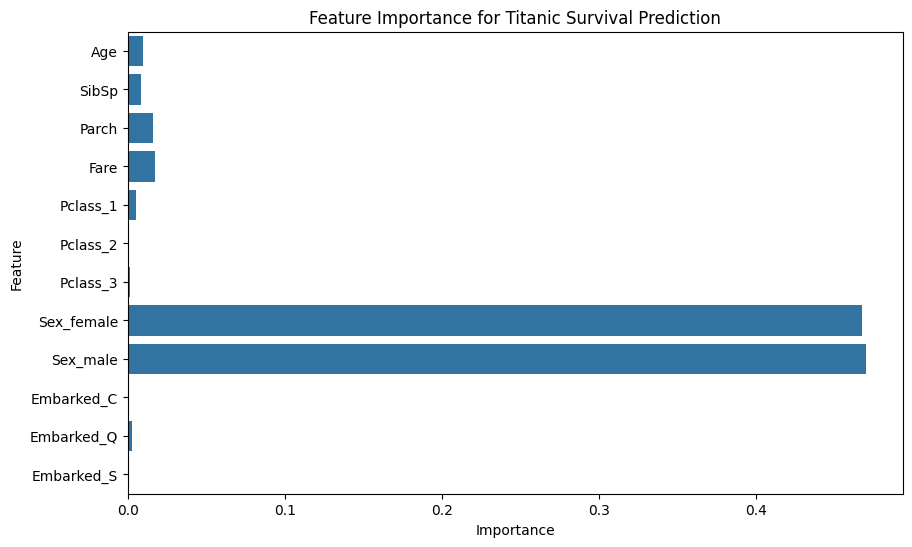

In [4]:
# Feature importance analysis
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_train_processed, y_train)

# Plot feature importance
feature_importance = pd.Series(rf_temp.feature_importances_, index=feature_names)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance for Titanic Survival Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.show()

In [5]:
# Train and evaluate the model
# Create a pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nTest Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Cross-validation accuracy: 1.0000 ± 0.0000

Test Set Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [6]:
# Cell: Additional Metrics (Balanced Accuracy, Cohen’s Kappa, MCC, Specificity)
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, confusion_matrix

# Calculate additional metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Specificity = TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Cohen’s Kappa:    {kappa:.4f}")
print(f"Matthews Corr:    {mcc:.4f}")
print(f"Specificity:      {specificity:.4f}")


Balanced Accuracy: 1.0000
Cohen’s Kappa:    1.0000
Matthews Corr:    1.0000
Specificity:      1.0000


In [7]:
# Cell: Classification Report (with support)
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=['Not Survived', 'Survived'],
    digits=4
))


Classification Report:

              precision    recall  f1-score   support

Not Survived     1.0000    1.0000    1.0000        53
    Survived     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        84
   macro avg     1.0000    1.0000    1.0000        84
weighted avg     1.0000    1.0000    1.0000        84



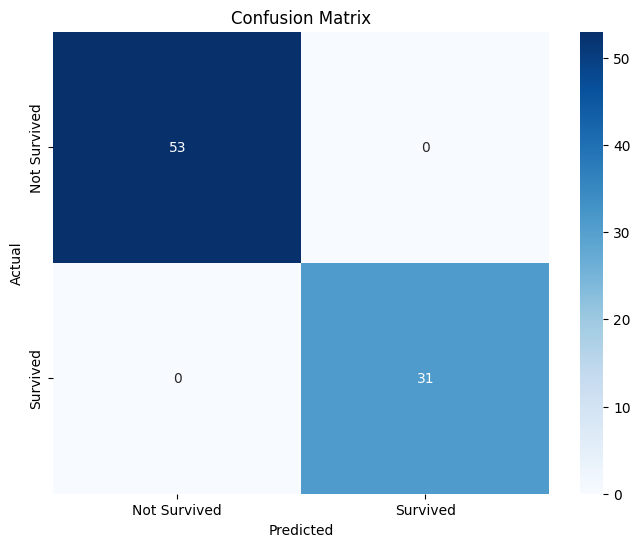

In [8]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

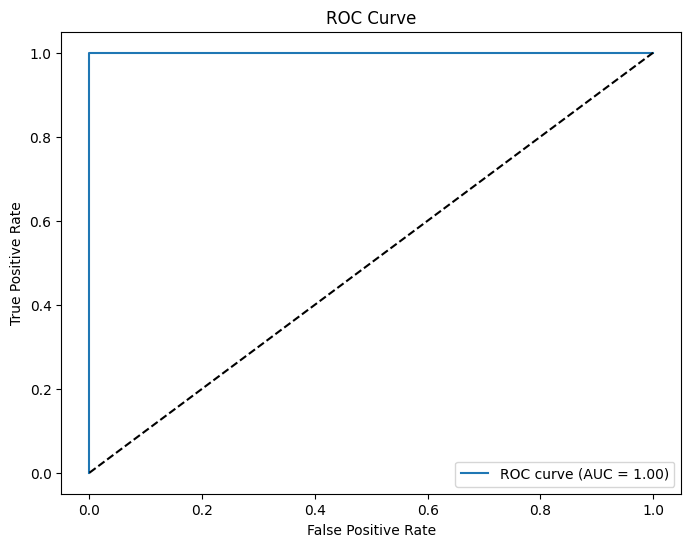

In [9]:
# Cell: ROC Curve & AUC
from sklearn.metrics import roc_auc_score, roc_curve

# get predicted probabilities for the positive class
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


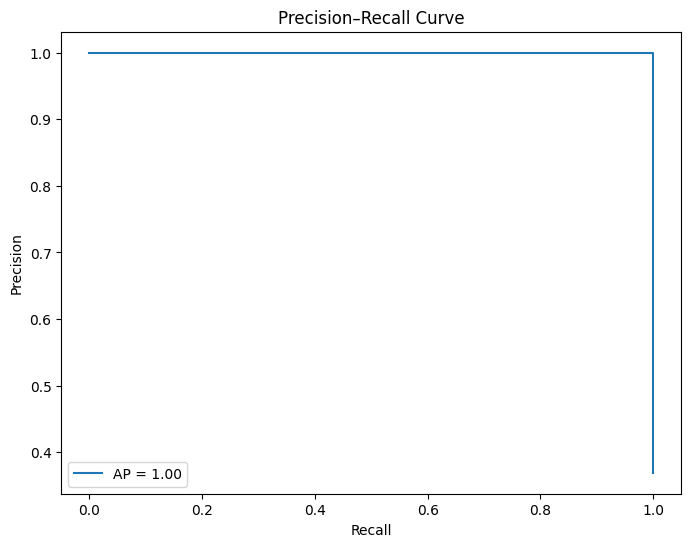

In [10]:
# Cell: Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
avg_prec = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'AP = {avg_prec:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.savefig('precision_recall_curve.png')
plt.show()


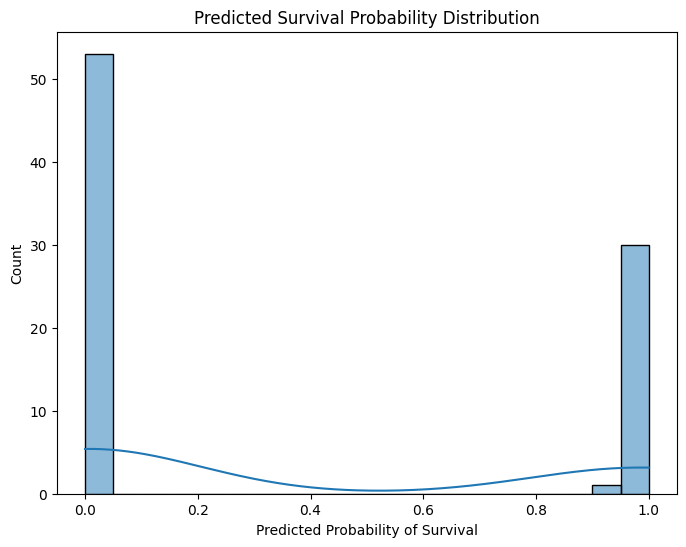

In [11]:
# Cell: Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title('Predicted Survival Probability Distribution')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Count')
plt.savefig('predicted_prob_dist.png')
plt.show()


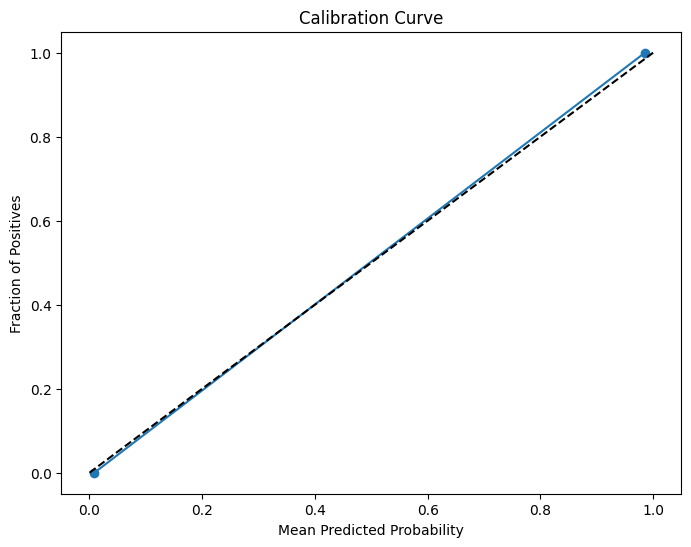

In [12]:
# Cell: Calibration Curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.savefig('calibration_curve.png')
plt.show()


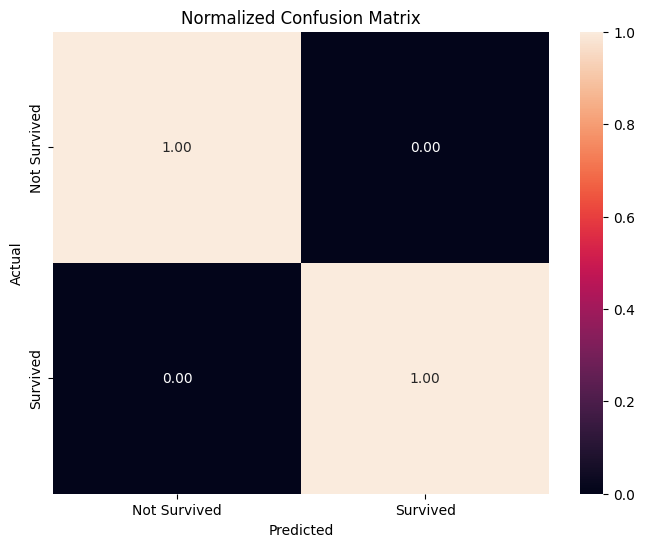

In [13]:
# Cell: Normalized Confusion Matrix
from sklearn.metrics import confusion_matrix

cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=['Not Survived','Survived'],
            yticklabels=['Not Survived','Survived'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_normalized.png')
plt.show()


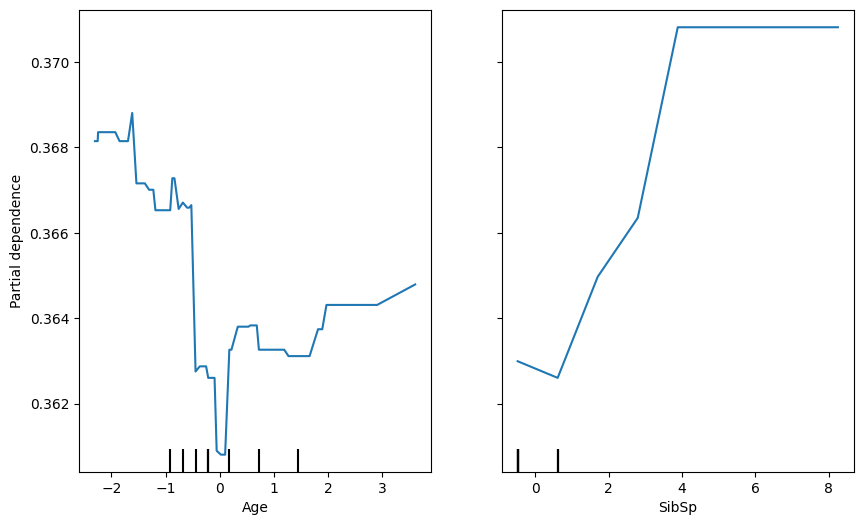

In [14]:
from sklearn.inspection import PartialDependenceDisplay

# Fit the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)

# Select features for partial dependence (e.g., first two numerical features)
features = [0, 1]  # Adjust indices based on your feature_names (e.g., 'Age', 'Fare')

# Plot partial dependence
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_train_processed, features, feature_names=feature_names, ax=ax)
plt.savefig('partial_dependence.png')
plt.show()

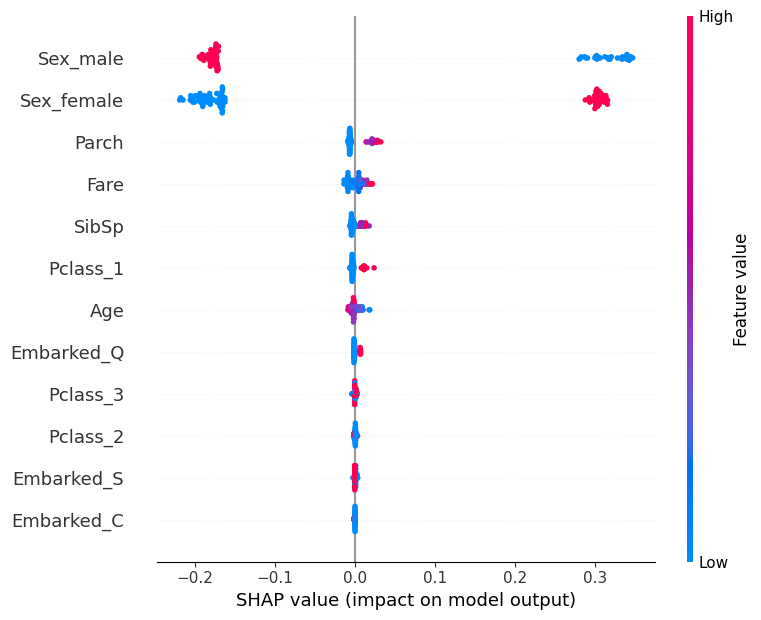

In [15]:
import shap
import matplotlib.pyplot as plt

# Fit the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_processed)



# Assuming feature_names is a list of 12 feature names
shap.summary_plot(shap_values[:, :, 1], X_test_processed, feature_names=feature_names, show=False)
plt.savefig('shap_summary.png')
plt.show()